/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The width is 478
The height is 850
The fps is 15.0


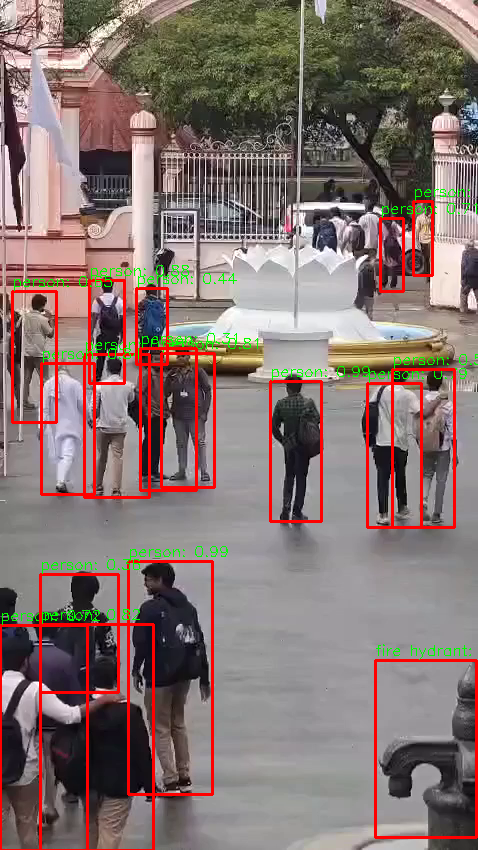

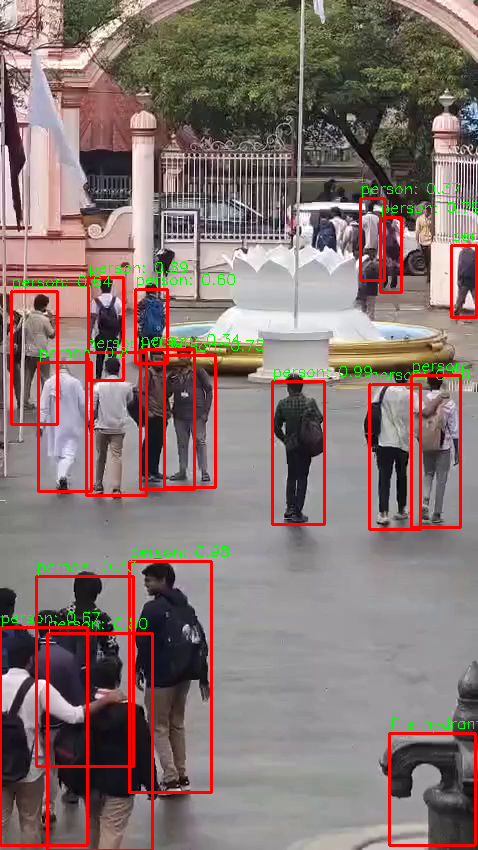

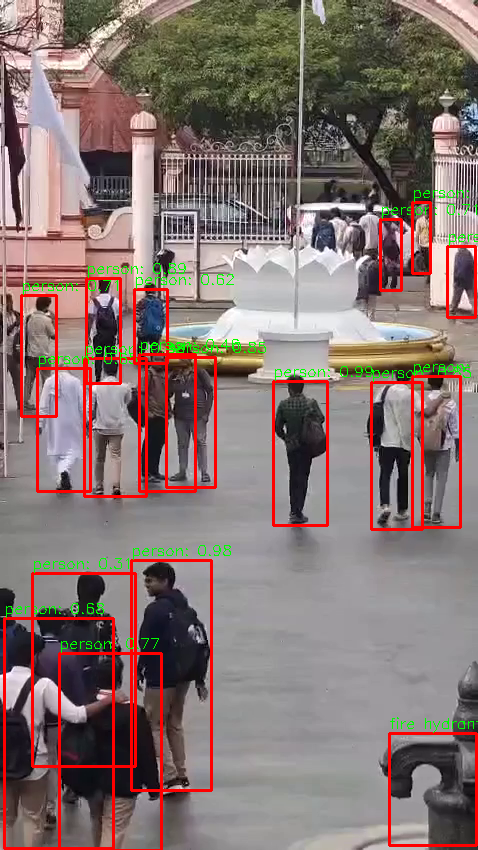

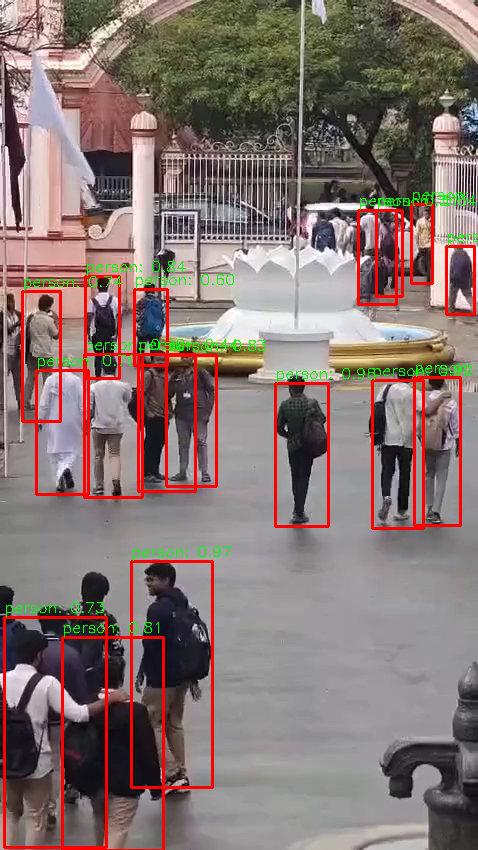

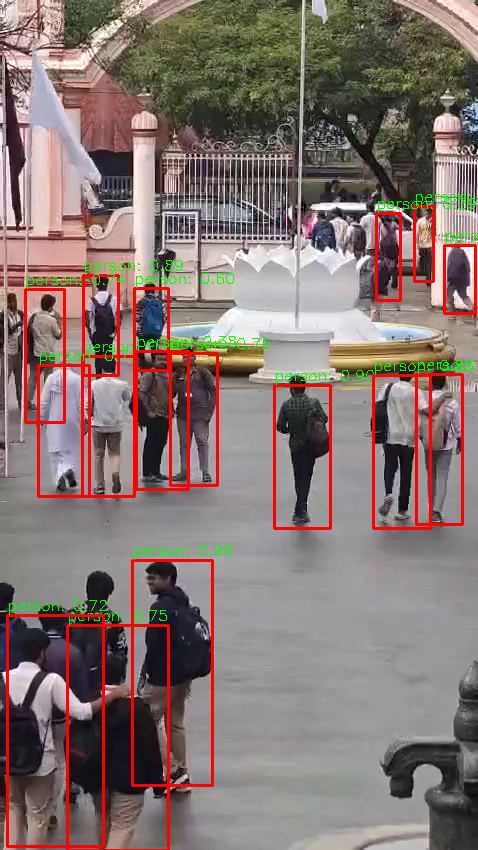

In [ ]:
import torch
import torchvision
from torchvision import transforms as T
import cv2
from google.colab.patches import cv2_imshow

# Load SSD300 pretrained model
model = torchvision.models.detection.ssd300_vgg16(pretrained=True)
model.eval()

# Transform
imgtransform = T.ToTensor()

# COCO class labels for SSD
COCO_INSTANCE_CATEGORY_NAMES = [
    '_background_', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
    'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite',
    'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
    'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table',
    'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock',
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Video input/output
video_path = "/content/amrita.mp4"
cap = cv2.VideoCapture(video_path)

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
print("The width is", width)
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print("The height is", height)
fps = cap.get(cv2.CAP_PROP_FPS)
print("The fps is", fps)

out = cv2.VideoWriter('/content/ssd_video_amrita.mp4',
                      cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

frame_count = 0
max_frames_to_show = 5

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    img = frame.copy()

    # Resize frame for SSD300
    img_resized = cv2.resize(img, (300, 300))
    image = imgtransform(img_resized)

    with torch.no_grad():
        ypred = model([image])
        boxes = ypred[0]['boxes']
        scores = ypred[0]['scores']
        labels = ypred[0]['labels']  # class indices

        conf_thresh = 0.30
        mask = scores > conf_thresh
        boxes = boxes[mask]
        labels = labels[mask]
        scores = scores[mask]

        # Scale boxes back to original frame size
        for i in range(len(boxes)):
            x_min, y_min, x_max, y_max = boxes[i].numpy()
            x_min = int(x_min * width / 300)
            y_min = int(y_min * height / 300)
            x_max = int(x_max * width / 300)
            y_max = int(y_max * height / 300)

            # Draw bounding box
            cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)

            # Get class name + confidence
            class_name = COCO_INSTANCE_CATEGORY_NAMES[labels[i].item()]
            conf = scores[i].item()

            cv2.putText(img, f"{class_name}: {conf:.2f}", (x_min, y_min - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    out.write(img)

    if frame_count < max_frames_to_show:
        cv2_imshow(img)
        frame_count += 1


cap.release()
out.release()